# Прогнозирование модели оттока клиентов

### План работы

1. [Знакомство с исходными данными](#1)
2. [Список уточняющих вопросов](#2)
3. [Предварительный план работы](#3)
    - 3.1. [Исследовательский анализ данных](#31)
    - 3.2. [Предобработка данных](#32)
    - 3.3. [Объединение данных из разных файлов](#33)
    - 3.4. [Подготовка данных для обучения](#34)
    - 3.5. [Обучение модели](#35)
    - 3.6. [Тестирование модели](#36)
    - 3.7. [Анализ влияния исходных признаков](#37)    
    - 3.8. [Описание результатов и выводов](#38)  


<a id="1"></a>
## Знакомство с исходными данными

По представленным данным попробуем определить что же означают признаки, добавим интерпретации в раздел выше.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [2]:
print('Начнем с файла contract.csv')
contract_data = pd.read_csv('contract.csv', index_col=[0])
print(contract_data.head())
print()
print('Размер выборки и общее описание данных')
print(contract_data.shape)
print()
print(contract_data.info())
print()
print('Общий процент пропусков по признакам')
print(contract_data.isnull().sum()*100/len(contract_data))
print()
print('Есть ли дубликаты?')
print(contract_data.duplicated().sum())
print('Нет, отлично! А по уникальным пользователям?')
print(contract_data['customerID'].duplicated().sum())


Начнем с файла contract.csv
   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  

Размер выборки и общее описание данных
(7043, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries

Отметим следующее, данные содержат записи по 7043 пользователям. Пропусков в данных нет, а вот с типами данных еще предстоит разобраться. Дубликатов среди уникальных ID клиентов не найдено. Посмотрим более внимательно на значения: 

In [3]:
contract_data['BeginDate'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

База ведется аж с октября 2013 года. Везде указано 1ое число, так что из ценного в данно признаке - только месяц и год

In [4]:
contract_data['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

Интересно, что информация о прекращении действия договора есть только с октября 2019 года и по настоящий момент. Видимо ранее этот факт в базе не фиксировался..

In [5]:
contract_data['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [6]:
contract_data['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [7]:
contract_data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [8]:
contract_data['MonthlyCharges'].describe()

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: MonthlyCharges, dtype: float64

In [9]:
contract_data['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

Первичный просмотр мы закончили, выявили несколько категорийных признаков, и заодно оценили распределение ежемесяной (абонентской?) платы. Среднее значение - около 60 у.е., для половины клиентов она находится в диапазоне от 35 до 90 у.е. При этом максимальная стоимость не столь существенно отличается от 75% квартиля и составляет до 118.75 у.е. Минимальная оплата соствляет 18.25 у.е.

Перейдем теперь к файлу personal.csv:

In [10]:
personal_data = pd.read_csv('personal.csv', index_col=[0])
print(personal_data.head())
print()
print('Размер выборки и общее описание данных')
print(personal_data.shape)
print()
print(personal_data.info())
print()
print('Общий процент пропусков по признакам')
print(personal_data.isnull().sum()*100/len(personal_data))
print()

print('Есть ли дубликаты по уникальным пользователям?')
print(personal_data['customerID'].duplicated().sum())


   customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

Размер выборки и общее описание данных
(7043, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 330.1+ KB
None

Общий процент пропусков по признакам
customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype:

Длина выборки аналогичная, пропусков и дуюликатов не видно, все признаки похожи на категорийные, проверим это:

In [11]:
personal_data['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [12]:
personal_data['SeniorCitizen'].unique()

array([0, 1])

In [13]:
personal_data['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [14]:
personal_data['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

Точно, все признаки категорийные, тип данных нужно будет изменить на булев. Идём дальше, internet.scv:

In [15]:
internet_data = pd.read_csv('internet.csv', index_col=[0])
print(internet_data.head())
print()
print('Размер выборки и общее описание данных')
print(internet_data.shape)
print()
print(internet_data.info())
print()
print('Общий процент пропусков по признакам')
print(internet_data.isnull().sum()*100/len(internet_data))
print()

print('Есть ли дубликаты по уникальным пользователям?')
print(internet_data['customerID'].duplicated().sum())


   customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No  

Размер выборки и общее описание данных
(5517, 8)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID   

Тут уже интереснее, длина выборки составляет 5517 уникальных пользователей, делаем вывод о том, что ~ 79% от всех клиентов используют только услуги интернет связи и связанные с ней. Все признаки категорийные и означают либо тип подключения, либо использование дополнительных услуг. Пропусков, как и дуюликатов нет. Перейдем к посленднему файлу phone.csv:

In [16]:
phone_data = pd.read_csv('phone.csv', index_col=[0])
print(phone_data.head())
print()
print('Размер выборки и общее описание данных')
print(phone_data.shape)
print()
print(phone_data.info())
print()
print('Общий процент пропусков по признакам')
print(phone_data.isnull().sum()*100/len(phone_data))
print()

print('Есть ли дубликаты по уникальным пользователям?')
print(phone_data['customerID'].duplicated().sum())


   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

Размер выборки и общее описание данных
(6361, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB
None

Общий процент пропусков по признакам
customerID       0.0
MultipleLines    0.0
dtype: float64

Есть ли дубликаты по уникальным пользователям?
0


Длина выборки - 6361 запись или около 90% клиентов. То есть большая часть клиентов пользуется услугами связи, чуть меньшая доля - интернет услугами. В данном файле всего один признак кроме уникального ID - категорийный, означающий подключены ли несколько линий. Тип его следует изменить. Пропусков и дубликатов все также нет.

<a id="2"></a>
## Список уточняющих вопросов

1. contract.csv: TotalCharges - это общая сумма платежей за период действия договора или за период времени, раз в который происходит оплата?
2. partner.csv: SeniorCitizen - городской житель?
3. partner.csv: Partner - является ли участником партнерской программы?
4. partner.csv: Dependents - отметка о том, получает ли помощь/скидку?
5. Выбор метрики при обучении модели
6. Как подходить к построению модели оттока: задача временного прогнозирования или стационарного?

<a id="31"></a>
### Исследовательский анализ данных
Рассмотрим более внимательно поведение всех и ушедших клиентов. Сравним распределения величин ежемесячных платежей (MonthlyCharges) для этих групп. Для каждой группы посчитайте статистики: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

Сравните поведение клиентов этих двух групп. Для каждой постройте два любых графика, изображающих:

долю пользователей телефонной связи; долю интернет-пользователей

In [17]:
print(contract_data.head())
print()
print(contract_data.info())

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Co

In [18]:
contract_data_gone = contract_data[contract_data['EndDate'] != 'No']
print('Всего клиентов: ', len(contract_data))
print('Всего ушло ', len(contract_data_gone),  'клиентов')

Всего клиентов:  7043
Всего ушло  1869 клиентов


In [19]:
print('Доли всех клиентов по частоте оплаты')
print()
print(contract_data.groupby('Type')['customerID'].count()/len(contract_data))
print()

print('Доли ушедших клиентов по частоте оплаты')
print()
print(contract_data_gone.groupby('Type')['customerID'].count()/len(contract_data_gone))

Доли всех клиентов по частоте оплаты

Type
Month-to-month    0.550192
One year          0.209144
Two year          0.240664
Name: customerID, dtype: float64

Доли ушедших клиентов по частоте оплаты

Type
Month-to-month    0.885500
One year          0.088818
Two year          0.025682
Name: customerID, dtype: float64


Замечаем первое существенное различие в долях пользователей по частоте оплаты, почти все ушедшие клиенты ежемесячно платили за услуги. Это можно объяснить отсутствием дисконта при ежемесячной тарификации по сравнению с 1/2 годовой.

In [20]:
print('Доли всех клиентов по типу выставления счетов')
print()
print(contract_data.groupby('PaperlessBilling')['customerID'].count()/len(contract_data))
print()

print('Доли ушедших клиентов по типу выставления счетов')
print()
print(contract_data_gone.groupby('PaperlessBilling')['customerID'].count()/len(contract_data_gone))

Доли всех клиентов по типу выставления счетов

PaperlessBilling
No     0.407781
Yes    0.592219
Name: customerID, dtype: float64

Доли ушедших клиентов по типу выставления счетов

PaperlessBilling
No     0.250936
Yes    0.749064
Name: customerID, dtype: float64


И по типу выставления счетов можно заметить разницу, среди ушедших клиентов большая (по сравнению со всеми клиентами) доля использовала электронное выставление счетов.

In [21]:
print('Доли всех клиентов по способу оплаты')
print()
print(contract_data.groupby('PaymentMethod')['customerID'].count()/len(contract_data))
print()

print('Доли ушедших клиентов по способу оплаты')
print()
print(contract_data_gone.groupby('PaymentMethod')['customerID'].count()/len(contract_data_gone))

Доли всех клиентов по способу оплаты

PaymentMethod
Bank transfer (automatic)    0.219225
Credit card (automatic)      0.216101
Electronic check             0.335794
Mailed check                 0.228880
Name: customerID, dtype: float64

Доли ушедших клиентов по способу оплаты

PaymentMethod
Bank transfer (automatic)    0.138042
Credit card (automatic)      0.124131
Electronic check             0.573034
Mailed check                 0.164794
Name: customerID, dtype: float64


Выявили еще одно важное отличие - доля использующих автоматические платежи среди ушедших чуть ли не вдвое ниже, чем у всех клиентов. И это логично, довольный и доверяющий сервису пользователь сведет на минимум время рутинного процесса оплаты, в то время как сомневающийся в качестве услуг клиент может и не захотеть "привязывать" карту, подключать автоплатежи и т.п. 

In [22]:
print('Ежемесячные расходы всех пользователей')
contract_data.describe()


Ежемесячные расходы всех пользователей


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [23]:
print('Ежемесячные расходы ушедших пользователей')
contract_data_gone.describe()

Ежемесячные расходы ушедших пользователей


,MonthlyCharges
count,1869.000000
mean,74.441332
std,24.666053
min,18.850000
25%,56.150000
50%,79.650000
75%,94.200000
max,118.350000


Можно сделать вывод о том, что ушедшие пользователи переплачивали в среднем 10 у.е. по сравнению со всеми клиентами, что составляет от 15 до 20% от среднего счета. Существенная разница. Построим распределения среди этих 2 групп:

Распределение ежемесячной стоимости услуг для всех клиентов


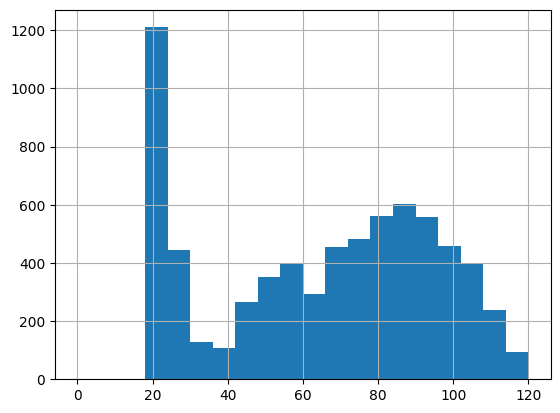

Распределение ежемесячной стоимости услуг для ушедших клиентов


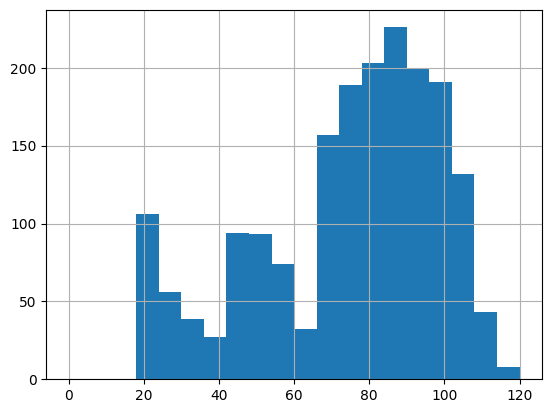

In [24]:
print('Распределение ежемесячной стоимости услуг для всех клиентов')
contract_data['MonthlyCharges'].hist(bins = 20, range = (0, 120))
plt.show()
print('Распределение ежемесячной стоимости услуг для ушедших клиентов')
contract_data_gone['MonthlyCharges'].hist(bins = 20, range = (0, 120))
plt.show()

График распределения помогает дополнить сделанный вывод. Пики распределения на одних и тех же значениях, около 20 у.е в месяц, около 50, и около 90.. Но при этом среди ушедших существенно реже представлена группа "экономных" клиентов, и существенно больше "премиальных". Напрашивается вывод, что премиальный сегмент не устраивает качество работы сервисов.. Посмотрим теперь, какие услуги приобретали эти 2 рассматриваемые группы:

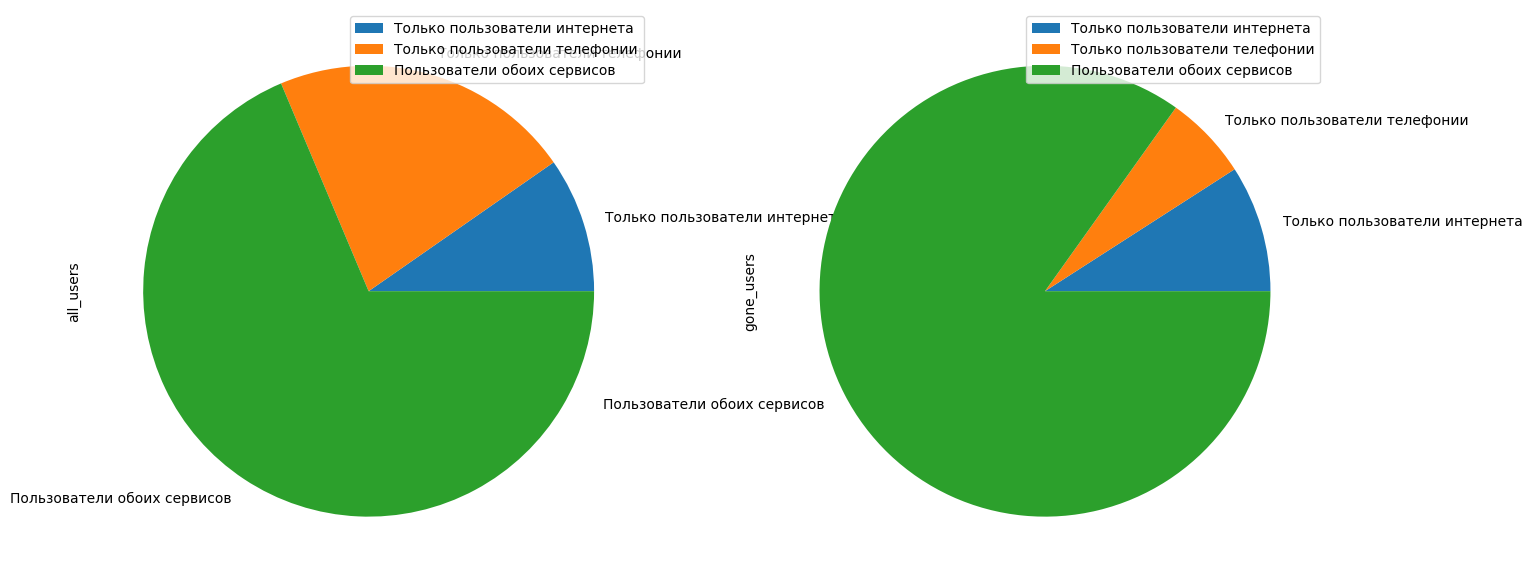

In [25]:
all_int = (len(contract_data)-len(phone_data))/len(contract_data)
all_tel = (len(contract_data) -len(internet_data))/len(contract_data)
all_2 = (len(phone_data)+len(internet_data)-len(contract_data))/len(contract_data)

gone_id = list(contract_data_gone['customerID'])

total_gone = len(contract_data_gone)
total_gone_int = len(internet_data[internet_data['customerID'].isin(gone_id) == True])
total_gone_tel = len(phone_data[phone_data['customerID'].isin(gone_id) == True])

gone_int = (total_gone - total_gone_tel)/total_gone
gone_tel = (total_gone - total_gone_int)/total_gone
gone_2 = (total_gone_tel+total_gone_int-total_gone)/total_gone

distr = pd.DataFrame({'all_users': [all_int, all_tel, all_2],
                    'gone_users': [gone_int, gone_tel, gone_2]},
                    index = ['Только пользователи интернета', 'Только пользователи телефонии', 'Пользователи обоих сервисов'])

distr.plot(kind = 'pie', subplots=True, figsize=(16, 9))
plt.show()

К интересному наблюдению мы пришли, посмотрев на долю клиентов интернет-сервиса, телефонии и обоих сразу в составе общей группы клиентов и ушедших: порядка 30% всех клиентов используют только один сервис, а вот из ушедших доля таковых была около 15%. Причем во многом это объясняется тем, что существенно (почти в 3 раза) ниже доля использующих только телефонию, хотя доля использующих интернет-сервисы практически идентичная. Напрашивается такое объяснение - ушедшие пользователи не всегда нуждались в обоих сервисах, хотя и платили за оба.

<a id="32"></a>
### Предобработка данных
В данном разделе для каждого из файлов проведем предобработку данных. Первые выводы по набору необходимых действий были сделаны в разделе знакомства с данными, приступим. Начнем с contract_data, а ниже приведем план по всем признакам:
- customerID - пока что не трогаем, он нам нужен для слияния таблиц. Перед обучением данный признак удалим
- BeginDate, EndDate - даты из этих столбцов рекомендовано удалить. Но перед этим надо извлечь полезные признаки. Попробуем для начала из столбца EndDate получить значение целевого признака, и заменить две даты на срок действия договора, заменив предварительно значения 'No' в столбце EndDate на 2020-02-01 (на эту дату информация актуальна).
- Type, PaperlessBilling, PaymentMethod - пока что не трогаем, после объединения проведем категоризацию
- MonthlyCharges, TotalCharges - приведем к нужному типу данных

In [26]:
print(contract_data.head())
print()
print(contract_data.info())

   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Co

In [27]:
#создаем целевой столбец
contract_data['gone'] = contract_data['MonthlyCharges']
contract_data.loc[contract_data['EndDate'] == 'No','gone'] = 0
contract_data.loc[contract_data['EndDate'] != 'No','gone'] = 1
contract_data['gone'] = contract_data['gone'].astype(int)




In [28]:
#Извлечение признаков из столбцов BeginDate и EndDate
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d')

contract_data.loc[contract_data['EndDate'] == 'No', 'EndDate'] = '2020-02-01 00:00:00'
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format = '%Y-%m-%d %H:%M:%S')

contract_data['contract_duration'] = contract_data['EndDate'] - contract_data['BeginDate']
contract_data['contract_duration'] = contract_data['contract_duration'].dt.days
# целевой признак и продолжительность действия контракта (в днях) мы добавили, удалим теперь исходные столбцы






In [29]:
# И изменим наконец тип данных в столбце TotalCharges на float
#contract_data['TotalCharges'] = contract_data['TotalCharges'].astype(float)
contract_data['TotalCharges'] = contract_data['TotalCharges'].replace(r'^\s*$', np.nan, regex=True)
contract_data['TotalCharges'] = contract_data['TotalCharges'].astype(float)

# Проверим, не появились ли проппуски после замены 

print(contract_data[contract_data['TotalCharges'].isna() == True].head(20))
# Видим, что для тех пользователей, которые только подписали контракт (время действия контракта = 0), 
# появились пропуски в столбце TotalCharges. Эти поля логично заменить на 0, поскольку фактически пользователи 
# только подключились, и не факт что внесли предоплату. А если и внесли, вероятно могут ее вернуть.

contract_data['TotalCharges'] = contract_data['TotalCharges'].fillna(0)

#проверка
print('Общий процент пропусков по признакам')
print(contract_data.isnull().sum()*100/len(contract_data))


contract_data.info()






      customerID  BeginDate    EndDate      Type PaperlessBilling  \
488   4472-LVYGI 2020-02-01 2020-02-01  Two year              Yes   
753   3115-CZMZD 2020-02-01 2020-02-01  Two year               No   
936   5709-LVOEQ 2020-02-01 2020-02-01  Two year               No   
1082  4367-NUYAO 2020-02-01 2020-02-01  Two year               No   
1340  1371-DWPAZ 2020-02-01 2020-02-01  Two year               No   
3331  7644-OMVMY 2020-02-01 2020-02-01  Two year               No   
3826  3213-VVOLG 2020-02-01 2020-02-01  Two year               No   
4380  2520-SGTTA 2020-02-01 2020-02-01  Two year               No   
5218  2923-ARZLG 2020-02-01 2020-02-01  One year              Yes   
6670  4075-WKNIU 2020-02-01 2020-02-01  Two year               No   
6754  2775-SEFEE 2020-02-01 2020-02-01  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges  gone  \
488   Bank transfer (automatic)           52.55           NaN     0   
753                Mailed che

In [30]:
#Теперь порядок, осталось удалить столбцы с датами:
del contract_data['BeginDate']
del contract_data['EndDate']

Теперь порядок. Поскольку в остальных файлах были одни категориальные признаки, перейдем к объединению данных.

<a id="33"></a>
### Объединение данных из разных файлов 

In [31]:
data = contract_data.copy()

data = data.merge(personal_data, on='customerID', how='left') 

data = data.merge(internet_data, on = 'customerID', how = 'left')


print(data.head())
print()
print(data.info())

# Проверим пропуски в данных полеобъединения:
print()
print('Общий процент пропусков по признакам')
print(data.isnull().sum()*100/len(data))

   customerID            Type PaperlessBilling              PaymentMethod  \
0  7590-VHVEG  Month-to-month              Yes           Electronic check   
1  5575-GNVDE        One year               No               Mailed check   
2  3668-QPYBK  Month-to-month              Yes               Mailed check   
3  7795-CFOCW        One year               No  Bank transfer (automatic)   
4  9237-HQITU  Month-to-month              Yes           Electronic check   

   MonthlyCharges  TotalCharges  gone  contract_duration  gender  \
0           29.85         29.85     0                 31  Female   
1           56.95       1889.50     0               1036    Male   
2           53.85        108.15     1                 61    Male   
3           42.30       1840.75     0               1371    Male   
4           70.70        151.65     1                 61  Female   

   SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0              0     Yes         No             DSL       

Ясно, что по тем пользователям, которые не пользовались интернет-услугами, у нас появились пропуски. Поскольку пропуски в категориальных признаках, надо выделить пропущенные значения к отдельной категории. Поскольку после объединения мы будем проводить категоризацию данных, заменим NaN на 'nodata'. Таким способом мы отделим пользователей, не использующих интернет в отдельную категорию.

In [32]:
data = data.fillna('nodata')
print(data.tail(20))

      customerID            Type PaperlessBilling              PaymentMethod  \
7023  1035-IPQPU  Month-to-month              Yes           Electronic check   
7024  7398-LXGYX  Month-to-month              Yes    Credit card (automatic)   
7025  2823-LKABH  Month-to-month              Yes  Bank transfer (automatic)   
7026  8775-CEBBJ  Month-to-month              Yes  Bank transfer (automatic)   
7027  0550-DCXLH  Month-to-month               No               Mailed check   
7028  9281-CEDRU        Two year               No  Bank transfer (automatic)   
7029  2235-DWLJU  Month-to-month              Yes           Electronic check   
7030  0871-OPBXW  Month-to-month              Yes               Mailed check   
7031  3605-JISKB        One year               No    Credit card (automatic)   
7032  6894-LFHLY  Month-to-month              Yes           Electronic check   
7033  9767-FFLEM  Month-to-month              Yes    Credit card (automatic)   
7034  0639-TSIQW  Month-to-month        

In [33]:
data = data.merge(phone_data, on = 'customerID', how = 'left')
print('Количество пропусков')
print(len(data[data['MultipleLines'].isna() == True]))
print()
print(data['MultipleLines'].unique())
print()
data['MultipleLines'] = data['MultipleLines'].fillna('nodata')
print(data['MultipleLines'].unique())

# и итоговая проверка всех строк
print('Общий процент пропусков по признакам')
print(data.isnull().sum()*100/len(data))

Количество пропусков
682

[nan 'No' 'Yes']

['nodata' 'No' 'Yes']
Общий процент пропусков по признакам
customerID           0.0
Type                 0.0
PaperlessBilling     0.0
PaymentMethod        0.0
MonthlyCharges       0.0
TotalCharges         0.0
gone                 0.0
contract_duration    0.0
gender               0.0
SeniorCitizen        0.0
Partner              0.0
Dependents           0.0
InternetService      0.0
OnlineSecurity       0.0
OnlineBackup         0.0
DeviceProtection     0.0
TechSupport          0.0
StreamingTV          0.0
StreamingMovies      0.0
MultipleLines        0.0
dtype: float64


Ниже приведен анализ влияния категорийных переменных на отток клиентов и мультиколлинеарности факторов.
    
Будем использовать срезы и группировки для оценки влияния категорийных признаков, а для количественных переменных дополнительно рассмотрим boxplot и корреляционный анализ.


In [34]:
check_data = data.copy()
display(check_data.head())

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gone,contract_duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,nodata
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,nodata
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [35]:
check_data_gone = check_data[check_data['gone'] == 1]
check_data_stay = check_data[check_data['gone'] == 0]


ffeature = list(check_data.columns)
ffeature.remove('customerID')
ffeature.remove('MonthlyCharges')
ffeature.remove('TotalCharges')
ffeature.remove('gone')
ffeature.remove('contract_duration')

for feature in ffeature:
    print(feature)
    print()
    print('Распределение ушедших клиентов по признаку', feature)
    print(check_data_gone.groupby(check_data[feature])[feature].count()/len(check_data_gone))
    print()
    print('Распределение оставшихся клиентов по признаку', feature)
    print(check_data_stay.groupby(check_data[feature])[feature].count()/len(check_data_stay))
    print()
    print('--------------------------------------------------------------')


Type

Распределение ушедших клиентов по признаку Type
Type
Month-to-month    0.885500
One year          0.088818
Two year          0.025682
Name: Type, dtype: float64

Распределение оставшихся клиентов по признаку Type
Type
Month-to-month    0.429068
One year          0.252609
Two year          0.318322
Name: Type, dtype: float64

--------------------------------------------------------------
PaperlessBilling

Распределение ушедших клиентов по признаку PaperlessBilling
PaperlessBilling
No     0.250936
Yes    0.749064
Name: PaperlessBilling, dtype: float64

Распределение оставшихся клиентов по признаку PaperlessBilling
PaperlessBilling
No     0.464438
Yes    0.535562
Name: PaperlessBilling, dtype: float64

--------------------------------------------------------------
PaymentMethod

Распределение ушедших клиентов по признаку PaymentMethod
PaymentMethod
Bank transfer (automatic)    0.138042
Credit card (automatic)      0.124131
Electronic check             0.573034
Mailed check          

Матрица коэффициентов корреляции
                   MonthlyCharges  TotalCharges  contract_duration
MonthlyCharges           1.000000      0.651174           0.247754
TotalCharges             0.651174      1.000000           0.826109
contract_duration        0.247754      0.826109           1.000000



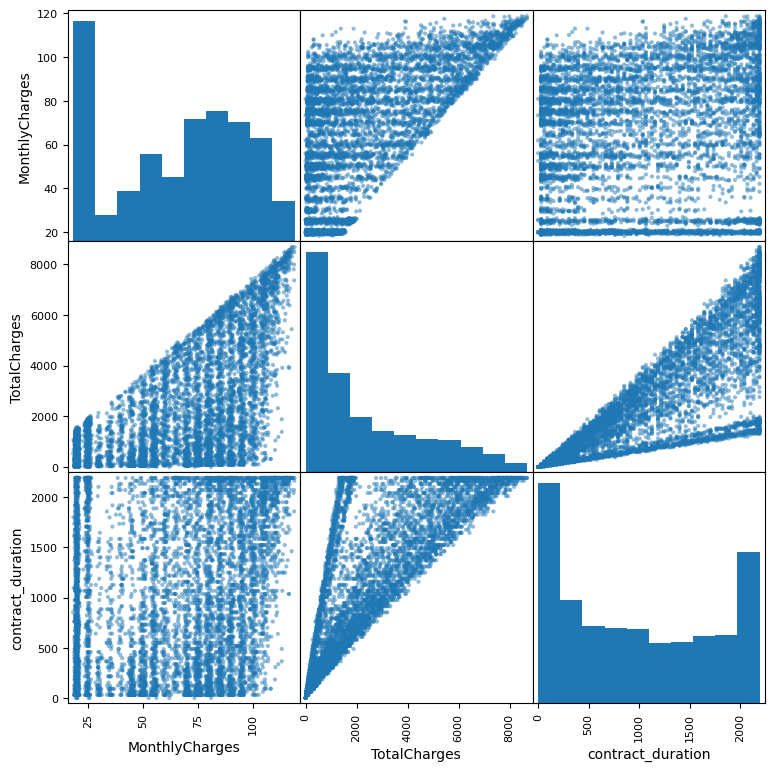

In [36]:
#проверка коэффициентов корреляции между признаками
print('Матрица коэффициентов корреляции')
print(check_data[['MonthlyCharges', 'TotalCharges', 'contract_duration']].corr())
print()
pd.plotting.scatter_matrix(check_data[['MonthlyCharges', 'TotalCharges', 'contract_duration']], figsize=(9, 9))
plt.show()

Ушедшие клиенты


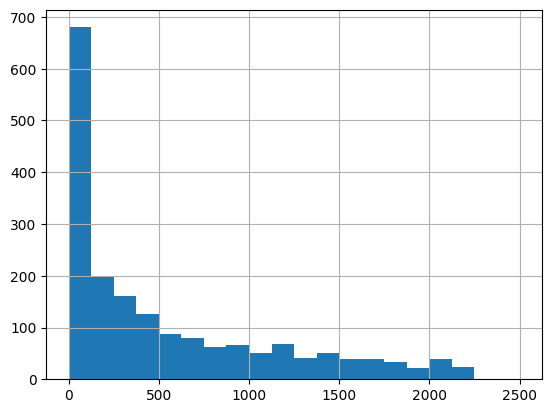

Оставшиеся клиенты


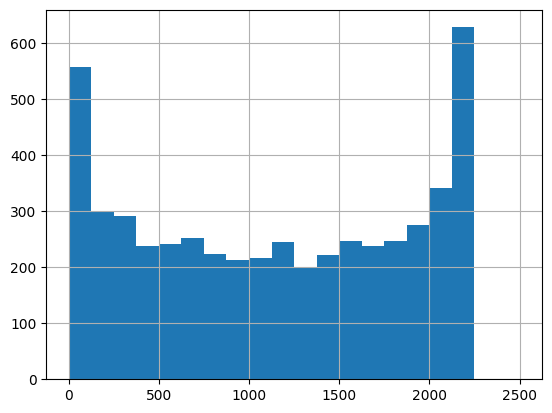

In [37]:
print('Ушедшие клиенты')
check_data_gone['contract_duration'].hist(bins=20, range = (0, 2500))
plt.show()
print('Оставшиеся клиенты')
check_data_stay['contract_duration'].hist(bins=20, range = (0, 2500))
plt.show()


__Выводы из исследования__

Результаты проведенной оценки влияния факторов на факт ухода клиента приведем тезисно ниже, начнем с категорийных признаков:
- Частота оплаты оказывает сущетсвенное влияние на факт ухода. Среди ушедщих клиентов абсолютное большинство платили ежемесячно, а из вот периодичность оплаты у оставшихся клиентов распределена примерно в равных долях.
- Распределение по типу расчёта (наличный/безналичный) также сильно отличается у ушедщих и оставшихся клиентов, среди ушедщих доля безналичного расчёта заметно выше
- Частота использования определенного способа оплаты услуг также существенно варьируется, у более половины ушедщих клиентов способ оплаты 'electornic check', а автоплатежи использовались в четверрти случаев. У оставшихся практически одинаковая частота использования способа оплаты.
- Пол клиента похожу не влияет на решение об уходе от нас, доли практически идентичны.
- Доля пенсионеров среди ушедших клиентов вдвое выше, 0.25 против 0.13, фактор отметать пока рано
- Перекос наблюдается и в долях пар, среди ушедших клиентов пар около трети, среди оставшихся - более половины, фактор не отметаем
- По наличию иждевенцев также есть небольшой перекос, среди оставшихся клиентов, доля таковых вдвое выше.
- По типу подключения разница еще интереснее, доля подключенных через оптоволоконный кабель вдвое выше среди ушедших. А также среди ушедших клиентов всего 6% не пользовались интернет услугами, в то время как из оставщихся их аж 27%. Может, разочарование кроме высокой стоимости еще и в качестве интернет услуг? В любом случае признак важный
- 85% ушудших клиентов не пользовались предлагаемым нами антивирусом, из оставшихся - всего 67%.
- Похожая картина и с услугой облака, около трети ушедших пользователей использовали данную услугу, из оставшихся - около половины.
- DEvice Protection - очень схожая картина с облаком. Тут, похоже один из факторов лишний.
- TechSupport - очень близкая картина к Антивирусу.
- StreamingTV - доля использования среди ушедщих и оставшихся клиентов примерно одинаковая. Фактор вряд ли оказывает существенное значение на факт ухода.
- StreamingMovies идентичная картина с StreamingTV
- MultipleLines - картина схожая у покинувших нас и оставшихся клиентов, как и доля не использующих тедефонные услуги.


А теперь перейдем к количественным признакам:
- Ранее мы уже приходили к выводу о том, что покинувшие нас клиенты зачастую переплачивали.
- Выведя матрицу коэффициентов корреляции, приходим у выводу, что пара MonthlyCharges - TotalCharges имеет корреляцию в 0,65 - вполне ожидаемо, пара TotalCharges - contract_duration коррелирует аж на 0,82.. При этом корреляции между MonthlyCharges и contract_duration нет. Проверив распределение продолжительности контракта для ушедших и оставшихся клиентов, видим существенно отличающуюся картину. Напрашивается вывод, что введенный нами признак продолжительности контракта может быть ценным, а вот TotalCharges можно будет и исключить позже. 


Предварительные выводы по исследованию следующие, проверим их после обучения моделей:
- gender скорее всего моно отбросить без существенной потери качества модели
- признаки Device protection и OnlineBackup - претендуют на мультиколлнеарность, важен скорее всего только один.
- признаки OnlineSecurity и TechSupport - претендуют на мультиколлнеарность, важен скорее всего только один.
- StreamingTV и StreamingMovies претендуют на мультиколлнеарность, скорее всего отбросим, причем оба
- MultipleLines скорее всего моно отбросить без существенной потери качества модели
- Вероятно, признак TotalCharges не несет ценности для качества модели.
    
</div>

<a id="34"></a>
### Подготовка данных для обучения

Выделим в данном разделе подэтапы:
- удаление лишних признаков
- категоризация данных
- масштабирование признаков
- анализ на дизбаланс классов и использование метода upsampling для избавления от него

 

In [38]:
data = data.drop('customerID', axis = 1)

data_ohe = pd.get_dummies(data, drop_first = True)
display(data_ohe.head())




,MonthlyCharges,TotalCharges,gone,contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nodata,OnlineSecurity_Yes,OnlineSecurity_nodata,OnlineBackup_Yes,OnlineBackup_nodata,DeviceProtection_Yes,DeviceProtection_nodata,TechSupport_Yes,TechSupport_nodata,StreamingTV_Yes,StreamingTV_nodata,StreamingMovies_Yes,StreamingMovies_nodata,MultipleLines_Yes,MultipleLines_nodata
0,29.85,29.85,0,31,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,56.95,1889.50,0,1036,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,53.85,108.15,1,61,0,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
3,42.30,1840.75,0,1371,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1
4,70.70,151.65,1,61,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [39]:
target = data_ohe['gone']
features = data_ohe.drop(['gone'], axis = 1)

#Подготовка обучающей и тестовой выборок:
features_train, features_second, target_train, target_second = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_second, target_second, test_size = 0.5, random_state = 12345)

#Проверка размерностей:
print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

#Масшиабирование признаков:
scaler = StandardScaler()
scaler.fit(features[features.columns])

features_train[features.columns] = scaler.transform(features_train[features.columns])
features_valid[features.columns] = scaler.transform(features_valid[features.columns])
features_test[features.columns] = scaler.transform(features_test[features.columns])
display(features_train.head())

(4225, 29)
(4225,)
(1409, 29)
(1409,)
(1409, 29)
(1409,)


,MonthlyCharges,TotalCharges,contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nodata,OnlineSecurity_Yes,OnlineSecurity_nodata,OnlineBackup_Yes,OnlineBackup_nodata,DeviceProtection_Yes,DeviceProtection_nodata,TechSupport_Yes,TechSupport_nodata,StreamingTV_Yes,StreamingTV_nodata,StreamingMovies_Yes,StreamingMovies_nodata,MultipleLines_Yes,MultipleLines_nodata
836,0.220630,0.973940,1.206638,-0.439916,1.944582,-0.562975,-1.205113,1.904590,-0.711026,-0.544807,0.990532,1.034530,1.529024,-0.885660,-0.525927,1.577454,-0.525927,-0.725563,-0.525927,1.381277,-0.525927,1.563872,-0.525927,-0.790132,-0.525927,1.256171,-0.525927,-0.854176,-0.327438
1005,1.033249,1.207304,0.840100,2.273159,1.944582,-0.562975,0.829798,1.904590,-0.711026,-0.544807,-1.009559,1.034530,-0.654012,1.129102,-0.525927,-0.633933,-0.525927,-0.725563,-0.525927,-0.723968,-0.525927,-0.639439,-0.525927,1.265612,-0.525927,1.256171,-0.525927,1.170719,-0.327438
4220,-1.504315,-0.552972,0.923039,-0.439916,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,1.835513,0.990532,1.034530,1.529024,-0.885660,1.901403,-0.633933,1.901403,-0.725563,1.901403,-0.723968,1.901403,-0.639439,1.901403,-0.790132,1.901403,-0.796070,1.901403,-0.854176,-0.327438
6543,-0.332748,0.505426,1.206638,-0.439916,1.944582,-0.562975,-1.205113,1.904590,-0.711026,-0.544807,-1.009559,1.034530,1.529024,-0.885660,-0.525927,1.577454,-0.525927,-0.725563,-0.525927,1.381277,-0.525927,-0.639439,-0.525927,-0.790132,-0.525927,-0.796070,-0.525927,-0.854176,-0.327438
272,-1.328164,-0.994838,-1.278865,-0.439916,-0.514249,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807,0.990532,-0.966622,-0.654012,-0.885660,-0.525927,-0.633933,-0.525927,-0.725563,-0.525927,-0.723968,-0.525927,-0.639439,-0.525927,-0.790132,-0.525927,-0.796070,-0.525927,-0.854176,3.054010


In [40]:
print('Количество ушедших клиентов (в %) = ',100*len(target_train[target_train == 1])/len(target_train))
print('Количество оставшихся клиентов (в %) = ',100*len(target_train[target_train == 0])/len(target_train))
print()
print('Количество ушедших клиентов (в %) = ',100*len(target_valid[target_valid == 1])/len(target_valid))
print('Количество оставшихся клиентов (в %) = ',100*len(target_valid[target_valid == 0])/len(target_valid))
print()
print('Количество ушедших клиентов (в %) = ',100*len(target_test[target_test == 1])/len(target_test))
print('Количество оставшихся клиентов (в %) = ',100*len(target_test[target_test == 0])/len(target_test))

Количество ушедших клиентов (в %) =  26.059171597633135
Количество оставшихся клиентов (в %) =  73.94082840236686

Количество ушедших клиентов (в %) =  27.111426543647976
Количество оставшихся клиентов (в %) =  72.88857345635202

Количество ушедших клиентов (в %) =  27.395315826827538
Количество оставшихся клиентов (в %) =  72.60468417317246


Наблюдаем существенный дисбаланс классов в обоих парах выборках, соотношение около 1:3. Попробуем сначала обучить, например, модель случайного леса на исходной выборке, а потом проверим, насколько sampling улучшит качество работы модели.

In [41]:
def model_test(test_model, features_train, target_train, features_valid, target_valid):
#    test_model = test_model
#    features_train = features_train
#    target_train = target_train
#    features_valid = features_valid
#    target_valid = target_valid
    test_model.fit(features_train, target_train)
    predictions_valid = test_model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    probabilities_valid = test_model.predict_proba(features_valid)[:,1]
    auc_roc = roc_auc_score(target_valid, probabilities_valid)
    print('Accuracy-мера для случайного леса =', accuracy)
    print('AUC-ROC мера для случайного леса = ', auc_roc)
    print('Полнота модели:',recall_score(target_valid, predictions_valid))
    print('Точность модели:', precision_score(target_valid, predictions_valid))
    return auc_roc


In [42]:
model = RandomForestClassifier(random_state = 12345)
model_test(model, features_train, target_train, features_valid, target_valid)


Accuracy-мера для случайного леса = 0.815471965933286
AUC-ROC мера для случайного леса =  0.8470230478647206
Полнота модели: 0.5314136125654451
Точность модели: 0.7147887323943662


0.8470230478647206

Попробуем использовать class_weight = 'balanced'

In [43]:
model= RandomForestClassifier(class_weight = 'balanced', random_state = 12345)
model_test(model, features_train, target_train, features_valid, target_valid)

Accuracy-мера для случайного леса = 0.8168914123491838
AUC-ROC мера для случайного леса =  0.8476322537559201
Полнота модели: 0.5287958115183246
Точность модели: 0.7214285714285714


0.8476322537559201

Толку с этого нет, пробуем sampling, напишем для этого функцию и попробуем увеличить в 3 раза трейн выборку для возвращения баланса классов

In [44]:
#Создание обучающей выборки методом upsampling
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)
print()

(6427, 29)
(6427,)



И попробуем еще раз обучить модель

In [45]:
model = RandomForestClassifier(random_state = 12345)
model_test(model, features_upsampled, target_upsampled, features_valid, target_valid)

Accuracy-мера для случайного леса = 0.815471965933286
AUC-ROC мера для случайного леса =  0.8497784937575514
Полнота модели: 0.6308900523560209
Точность модели: 0.6694444444444444


0.8497784937575514

<a id="35"></a>
### Обучение модели

В данном разделе мы обучим следующие модели:
- логистическая регрессия
- случайный лес
- catboost

Для двух последних будем также подбирать оптимальные параметры. Начнем с обучения и оценки качества логистической регрессии:

In [46]:
model = LogisticRegression()
model_test(model, features_upsampled, target_upsampled, features_valid, target_valid)

Accuracy-мера для случайного леса = 0.7508871540099361
AUC-ROC мера для случайного леса =  0.851483760457185
Полнота модели: 0.837696335078534
Точность модели: 0.5254515599343186


0.851483760457185

И это впечатляет, за минимальное время обучения получаем достойное значение метрики ROC-Auc, а вот значение метрики accuracy на 0.05 ниже чем у случайного леса на параметрах по умолчанию. Перейдем к случайному лесу:

In [47]:
top_depth = 0
top_roc_auc = 0
top_model_randfor = []



for depth in range(1,21,1):
    print('depth =', depth)
    model = RandomForestClassifier(max_depth = depth, n_estimators = 100, random_state = 12345)
    roc_auc = model_test(model, features_upsampled, target_upsampled, features_valid, target_valid)
    if roc_auc > top_roc_auc:
        top_roc_auc = roc_auc
        top_model_randfor = model
        top_depth = depth
   
    
    print()
    
print('Оптимальное значение depth =',top_depth)    
    

depth = 1
Accuracy-мера для случайного леса = 0.6586231369765791
AUC-ROC мера для случайного леса =  0.8135982911647304
Полнота модели: 0.8821989528795812
Точность модели: 0.4359637774902975

depth = 2
Accuracy-мера для случайного леса = 0.6905606813342796
AUC-ROC мера для случайного леса =  0.8346350117507916
Полнота модели: 0.8769633507853403
Точность модели: 0.462707182320442

depth = 3
Accuracy-мера для случайного леса = 0.716820440028389
AUC-ROC мера для случайного леса =  0.8418129355567224
Полнота модели: 0.8638743455497382
Точность модели: 0.4874446085672083

depth = 4
Accuracy-мера для случайного леса = 0.7281760113555713
AUC-ROC мера для случайного леса =  0.8487423339467876
Полнота модели: 0.8638743455497382
Точность модели: 0.49924357034795763

depth = 5
Accuracy-мера для случайного леса = 0.7430801987224982
AUC-ROC мера для случайного леса =  0.8525211947572606
Полнота модели: 0.8612565445026178
Точность модели: 0.5156739811912225

depth = 6
Accuracy-мера для случайного ле

Оптимальная глубина леса, определенная по максимуму метрики roc-auc составила 8. Метрика при этом достигла 0,86, а accuracy составил порядка 0.76. Но исходя из значения метрики accuracy, которая растет при увеличении глубины, вполне логично выбрать значение параметра 13, при котором метрика accuracy достигает 0.804, а roc-auc = 0.855.

In [48]:
top_estim = 0
top_roc_auc = 0
top_model_randfor = []



for estim in range(1,301,10):
    print('n_estimators =', estim)
    model = RandomForestClassifier(max_depth = 8, n_estimators = estim, random_state = 12345)
    roc_auc = model_test(model, features_upsampled, target_upsampled, features_valid, target_valid)
    if roc_auc > top_roc_auc:
        top_roc_auc = roc_auc
        top_model_randfor = model
        top_estim = estim
   
    
    print()
    
print('Оптимальное значение estim =',top_estim)    
    

n_estimators = 1
Accuracy-мера для случайного леса = 0.7267565649396736
AUC-ROC мера для случайного леса =  0.8299448910821434
Полнота модели: 0.7879581151832461
Точность модели: 0.4975206611570248

n_estimators = 11
Accuracy-мера для случайного леса = 0.7643718949609652
AUC-ROC мера для случайного леса =  0.8565638748553456
Полнота модели: 0.8141361256544503
Точность модели: 0.5437062937062938

n_estimators = 21
Accuracy-мера для случайного леса = 0.7650816181689141
AUC-ROC мера для случайного леса =  0.8593652023634131
Полнота модели: 0.8089005235602095
Точность модели: 0.544973544973545

n_estimators = 31
Accuracy-мера для случайного леса = 0.7608232789212207
AUC-ROC мера для случайного леса =  0.8620862370448162
Полнота модели: 0.8167539267015707
Точность модели: 0.538860103626943

n_estimators = 41
Accuracy-мера для случайного леса = 0.7665010645848119
AUC-ROC мера для случайного леса =  0.8625004460712592
Полнота модели: 0.8272251308900523
Точность модели: 0.5457685664939551

n_e

сузим диапазон и проверим лучшее значение n_estimators от 32 до 50

In [49]:
for estim in range(32,50,1):
    print('n_estimators =', estim)
    model = RandomForestClassifier(max_depth = 8, n_estimators = estim, random_state = 12345)
    roc_auc = model_test(model, features_upsampled, target_upsampled, features_valid, target_valid)
    if roc_auc > top_roc_auc:
        top_roc_auc = roc_auc
        top_model_randfor = model
        top_estim = estim
   
    
    print()
    
print('Оптимальное значение estim =',top_estim)    

n_estimators = 32
Accuracy-мера для случайного леса = 0.759403832505323
AUC-ROC мера для случайного леса =  0.8623003512492543
Полнота модели: 0.8141361256544503
Точность модели: 0.5371329879101899

n_estimators = 33
Accuracy-мера для случайного леса = 0.7608232789212207
AUC-ROC мера для случайного леса =  0.8618185942892683
Полнота модели: 0.8141361256544503
Точность модели: 0.5389948006932409

n_estimators = 34
Accuracy-мера для случайного леса = 0.759403832505323
AUC-ROC мера для случайного леса =  0.8618007514388986
Полнота модели: 0.8141361256544503
Точность модели: 0.5371329879101899

n_estimators = 35
Accuracy-мера для случайного леса = 0.7636621717530163
AUC-ROC мера для случайного леса =  0.8622060390401566
Полнота модели: 0.819371727748691
Точность модели: 0.5424610051993067

n_estimators = 36
Accuracy-мера для случайного леса = 0.7636621717530163
AUC-ROC мера для случайного леса =  0.8623309389927456
Полнота модели: 0.824607329842932
Точность модели: 0.5421686746987951

n_es

Итак мы получили оптимальные значения параметров depth = 9, n_estimators = 37. Значения метрик составили:

- Accuracy-мера для случайного леса = 0.763
- AUC-ROC мера для случайного леса =  0.863

Перейдем теперь к CatBoost

In [50]:
%%time
model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric='AUC', depth = 12, iterations=100, learning_rate = 0.01)
model_cb.fit(features_upsampled, target_upsampled, verbose=20)
cb_predictions = model_cb.predict_proba(features_valid)[:,1]
print(roc_auc_score(target_valid, cb_predictions))

0:	total: 71.4ms	remaining: 7.07s
20:	total: 671ms	remaining: 2.52s
40:	total: 1.17s	remaining: 1.69s
60:	total: 1.76s	remaining: 1.12s
80:	total: 2.33s	remaining: 546ms
99:	total: 2.92s	remaining: 0us
0.8579683620773155
CPU times: user 9.11 s, sys: 398 ms, total: 9.5 s
Wall time: 3.01 s


И сходу получаем близкие к оптимальному случайному лесу значения метрик, перспективы видны, займемся подбором параметров:

In [51]:
%%time
best_model_cb = None
best_result = 0
best_depth = 0
best_lrate = 0

for depth in range(1, 16, 3):
    for lrate in [0.01, 0.05, 0.1, 0.5]:
             
        model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = depth, iterations=200, learning_rate = lrate)
        model_cb.fit(features_upsampled, target_upsampled, verbose=40)
        cb_predictions = model_cb.predict(features_valid)
        cb_predictions_proba = model_cb.predict_proba(features_valid)[:,1]
        print('depth =', depth, 'learning rate =', lrate)
        print('Accuracy модели:',accuracy_score(target_valid, cb_predictions))
        print('ROC-AUC модели:',roc_auc_score(target_valid, cb_predictions_proba))
        print()        
        if roc_auc_score(target_valid, cb_predictions_proba) > best_result:
            best_result = roc_auc_score(target_valid, cb_predictions_proba)
            best_depth = depth
            best_lrate = lrate
            top_model_cb = model_cb
                
print('Наилучшие параметры модели: depth =', best_depth, 'learning rate =', best_lrate, '  ROC-AUC = ', best_result)

0:	total: 1.46ms	remaining: 290ms
40:	total: 31.8ms	remaining: 123ms
80:	total: 66.2ms	remaining: 97.3ms
120:	total: 93.4ms	remaining: 61ms
160:	total: 123ms	remaining: 29.9ms
199:	total: 156ms	remaining: 0us
depth = 1 learning rate = 0.01
Accuracy модели: 0.7246273953158269
ROC-AUC модели: 0.845892575844859

0:	total: 628us	remaining: 125ms
40:	total: 31.8ms	remaining: 123ms
80:	total: 65.3ms	remaining: 96ms
120:	total: 94.6ms	remaining: 61.8ms
160:	total: 129ms	remaining: 31.2ms
199:	total: 158ms	remaining: 0us
depth = 1 learning rate = 0.05
Accuracy модели: 0.7565649396735273
ROC-AUC модели: 0.8642719862151236

0:	total: 898us	remaining: 179ms
40:	total: 31.6ms	remaining: 123ms
80:	total: 72.4ms	remaining: 106ms
120:	total: 103ms	remaining: 67.5ms
160:	total: 135ms	remaining: 32.8ms
199:	total: 166ms	remaining: 0us
depth = 1 learning rate = 0.1
Accuracy модели: 0.7643718949609652
ROC-AUC модели: 0.866372344601518

0:	total: 737us	remaining: 147ms
40:	total: 33.7ms	remaining: 131ms
8

Прогнали параметры модели с небольшим количеством итераций для выявления удачных параметров, depth от 1 до 15 с шагом в 3, learning rate от 0.01 до 0.5 с шагом в пол порядка. Получили следующие перспективные наборы параметров, на которых построим более точные модели.

depth = 4 learning rate = 0.5
Accuracy модели: 0.8424414478353442
ROC-AUC модели: 0.9009033580244397

Интересно теперь посмотреть внимательнее на область depth от 2 до 6 (благо с такими параметрами модели обучаются быстро), и увеличить количество итераций, уменьшив при этом learning_rate

In [52]:
%%time
best_model_cb = None
best_result = 0
best_depth = 0
best_lrate = 0

for depth in range(2, 7, 1):
    for lrate in [0.01, 0.05, 0.1]:
             
        model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = depth, iterations=500, learning_rate = lrate)
        model_cb.fit(features_upsampled, target_upsampled, verbose=100)
        cb_predictions = model_cb.predict(features_valid)
        cb_predictions_proba = model_cb.predict_proba(features_valid)[:,1]
        print('depth =', depth, 'learning rate =', lrate)
        print('Accuracy модели:',accuracy_score(target_valid, cb_predictions))
        print('ROC-AUC модели:',roc_auc_score(target_valid, cb_predictions_proba))
        print()        
        if roc_auc_score(target_valid, cb_predictions_proba) > best_result:
            best_result = roc_auc_score(target_valid, cb_predictions_proba)
            best_depth = depth
            best_lrate = lrate
            top_model_cb = model_cb
                
print('Наилучшие параметры модели: depth =', best_depth, 'learning rate =', best_lrate, '  ROC-AUC = ', best_result)

0:	total: 1.35ms	remaining: 674ms
100:	total: 107ms	remaining: 423ms
200:	total: 221ms	remaining: 329ms
300:	total: 328ms	remaining: 217ms
400:	total: 435ms	remaining: 107ms
499:	total: 537ms	remaining: 0us
depth = 2 learning rate = 0.01
Accuracy модели: 0.7537260468417317
ROC-AUC модели: 0.8691086731546669

0:	total: 1.24ms	remaining: 618ms
100:	total: 107ms	remaining: 422ms
200:	total: 213ms	remaining: 316ms
300:	total: 325ms	remaining: 215ms
400:	total: 440ms	remaining: 109ms
499:	total: 554ms	remaining: 0us
depth = 2 learning rate = 0.05
Accuracy модели: 0.7799858055358411
ROC-AUC модели: 0.8780288238502832

0:	total: 1.01ms	remaining: 504ms
100:	total: 111ms	remaining: 439ms
200:	total: 223ms	remaining: 332ms
300:	total: 335ms	remaining: 221ms
400:	total: 451ms	remaining: 111ms
499:	total: 569ms	remaining: 0us
depth = 2 learning rate = 0.1
Accuracy модели: 0.7991483321504613
ROC-AUC модели: 0.8902753916505656

0:	total: 1.07ms	remaining: 532ms
100:	total: 122ms	remaining: 481ms
20

Выявили, что оптимальный depth = 4, а learning rate = 0.1 при количестве итераций в 500.

- depth = 3 learning rate = 0.1
- Accuracy модели: 0.813
- ROC-AUC модели: 0.901


- depth = 4 learning rate = 0.1
- Accuracy модели: 0.839
- ROC-AUC модели: 0.905


- depth = 5 learning rate = 0.1
- Accuracy модели: 0.833
- ROC-AUC модели: 0.904

Ну и подберем наконец оптимальную пару для depth = 4, и количества итераций в 1000, с более мелким шагом learning_rate:

In [53]:
%%time
best_model_cb = None
best_result = 0
best_depth = 0
best_lrate = 0

for lrate in np.arange(0.05, 0.202, 0.01):
             
    model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = 4, iterations=1000, learning_rate = lrate)
    model_cb.fit(features_upsampled, target_upsampled, verbose=200)
    cb_predictions = model_cb.predict(features_valid)
    cb_predictions_proba = model_cb.predict_proba(features_valid)[:,1]
    print('depth = 4, learning rate =', lrate)
    print('Accuracy модели:',accuracy_score(target_valid, cb_predictions))
    print('ROC-AUC модели:',roc_auc_score(target_valid, cb_predictions_proba))
    print()        
    if roc_auc_score(target_valid, cb_predictions_proba) > best_result:
        best_result = roc_auc_score(target_valid, cb_predictions_proba)
        best_depth = depth
        best_lrate = lrate
        top_model_cb = model_cb
                
print('Наилучшие параметры модели: learning rate =', best_lrate, '  ROC-AUC = ', best_result)

0:	total: 1.65ms	remaining: 1.64s
200:	total: 412ms	remaining: 1.64s
400:	total: 806ms	remaining: 1.2s
600:	total: 1.18s	remaining: 786ms
800:	total: 1.54s	remaining: 382ms
999:	total: 1.95s	remaining: 0us
depth = 4, learning rate = 0.05
Accuracy модели: 0.8332150461320085
ROC-AUC модели: 0.9055272052488568

0:	total: 1.13ms	remaining: 1.13s
200:	total: 370ms	remaining: 1.47s
400:	total: 763ms	remaining: 1.14s
600:	total: 1.14s	remaining: 759ms
800:	total: 1.51s	remaining: 374ms
999:	total: 1.88s	remaining: 0us
depth = 4, learning rate = 0.060000000000000005
Accuracy модели: 0.837473385379702
ROC-AUC модели: 0.9060051387409065

0:	total: 1.58ms	remaining: 1.58s
200:	total: 363ms	remaining: 1.44s
400:	total: 729ms	remaining: 1.09s
600:	total: 1.14s	remaining: 758ms
800:	total: 1.5s	remaining: 372ms
999:	total: 1.79s	remaining: 0us
depth = 4, learning rate = 0.07
Accuracy модели: 0.8445706174591909
ROC-AUC модели: 0.9087389183154311

0:	total: 1.28ms	remaining: 1.28s
200:	total: 374ms	re

Итак, на валидационной выборке оптимальные параметры модели оказались следующими:

- depth = 4
- learning_rate = 0.13

При этом достигнуто значение метрики Accuracy в 0,857, а ROC-AUC в 0.912.

Перед тем, как перейти к тестированию модели, объединим обучающую и валидационную выборки, и обучим на ней наилучшим образом зарекомендовавшую себя модель CatBoost на уже подобранных параметрах:

In [54]:
target = data_ohe['gone']
features = data_ohe.drop(['gone'], axis = 1)

#Подготовка обучающей и тестовой выборок:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)

scaler = StandardScaler()
scaler.fit(features[features.columns])

features_train[features.columns] = scaler.transform(features_train[features.columns])
features_test[features.columns] = scaler.transform(features_test[features.columns])
display(features_train.head())



features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)
print()





,MonthlyCharges,TotalCharges,contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nodata,OnlineSecurity_Yes,OnlineSecurity_nodata,OnlineBackup_Yes,OnlineBackup_nodata,DeviceProtection_Yes,DeviceProtection_nodata,TechSupport_Yes,TechSupport_nodata,StreamingTV_Yes,StreamingTV_nodata,StreamingMovies_Yes,StreamingMovies_nodata,MultipleLines_Yes,MultipleLines_nodata
1580,0.230601,-0.345307,-0.461512,2.273159,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807,-1.009559,1.034530,-0.654012,-0.885660,-0.525927,-0.633933,-0.525927,1.378241,-0.525927,1.381277,-0.525927,-0.639439,-0.525927,-0.790132,-0.525927,1.256171,-0.525927,1.170719,-0.327438
2902,0.310367,-0.806850,-1.072855,2.273159,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807,-1.009559,-0.966622,-0.654012,1.129102,-0.525927,1.577454,-0.525927,-0.725563,-0.525927,-0.723968,-0.525927,-0.639439,-0.525927,-0.790132,-0.525927,-0.796070,-0.525927,-0.854176,-0.327438
410,0.551328,-0.902675,-1.195926,2.273159,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807,0.990532,-0.966622,-0.654012,1.129102,-0.525927,-0.633933,-0.525927,1.378241,-0.525927,-0.723968,-0.525927,-0.639439,-0.525927,-0.790132,-0.525927,-0.796070,-0.525927,1.170719,-0.327438
6098,0.370192,-0.322057,-0.461512,-0.439916,1.944582,-0.562975,0.829798,-0.525047,-0.711026,-0.544807,0.990532,1.034530,1.529024,-0.885660,-0.525927,1.577454,-0.525927,-0.725563,-0.525927,-0.723968,-0.525927,-0.639439,-0.525927,1.265612,-0.525927,1.256171,-0.525927,1.170719,-0.327438
2930,-1.296590,-0.672422,-0.054842,-0.439916,-0.514249,1.776278,-1.205113,-0.525047,-0.711026,1.835513,0.990532,1.034530,1.529024,-0.885660,1.901403,-0.633933,1.901403,-0.725563,1.901403,-0.723968,1.901403,-0.639439,1.901403,-0.790132,1.901403,-0.796070,1.901403,1.170719,-0.327438


(8614, 29)
(8614,)



In [55]:
%%time
model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = 4, iterations=1000, learning_rate = 0.13)
model_cb.fit(features_upsampled, target_upsampled, verbose=200)


0:	total: 1.5ms	remaining: 1.5s
200:	total: 381ms	remaining: 1.51s
400:	total: 766ms	remaining: 1.14s
600:	total: 1.16s	remaining: 769ms
800:	total: 1.55s	remaining: 386ms
999:	total: 1.94s	remaining: 0us
CPU times: user 2.83 s, sys: 1.91 s, total: 4.74 s
Wall time: 2.01 s


<a id="36"></a>
### Тестирование модели

In [56]:
cb_predictions = model_cb.predict(features_test)
cb_predictions_proba = model_cb.predict_proba(features_test)[:,1]

print('Accuracy модели:',accuracy_score(target_test, cb_predictions))
print('ROC-AUC модели:',roc_auc_score(target_test, cb_predictions_proba))

print('Полнота модели:',recall_score(target_test, cb_predictions))
print('Точность модели:', precision_score(target_test, cb_predictions))



Accuracy модели: 0.8644428672817601
ROC-AUC модели: 0.9237940927837691
Полнота модели: 0.8179419525065963
Точность модели: 0.7175925925925926


In [57]:
d = {'Логистическая регрессия': [0.751, 0.851], 'Случайный лес': [0.763, 0.863], 'CatBoost': [0.864, 0.924]}
results = pd.DataFrame(data=d, index = ['Accuracy', 'AUC-ROC'])

<a id="38"></a>
### Описание предварительных результатов и выводов

Поскольку техническим заданием подразумевается отдельный раздел с формированием отчета о решении поставленной задачи, в данном блоке тезисно опишем проделанные шаги и полученные результаты:
- В ходе анализа данных по ряду признаков выявлены заметные отличия в поведении ушедщих клиентов и оставшихся
- В ходе обработки данных мы дополнительно извлекли информацию о сроке действия договора с клиентом и использовали его для обучения модели
- Для обучения моделей исходная выборка поделена на обучающую, валидационную и тестовую, проведено масштабирование признаков и применен метод upsampling для избавления от дисбаланса классов
- Обучены модели логистической регрессии, случайного леса и CatBoost. Для оптимальных параметров на валидационной выборке получены следующие значения метрик:


In [58]:
display(results)

,Логистическая регрессия,Случайный лес,CatBoost
Accuracy,0.751,0.763,0.864
AUC-ROC,0.851,0.863,0.924


С учетом полученных результатов была выбрана модель CatBoost. Время обучения составило менее 30 секунд. С целью повышения качества работы модели, мы также объединили обучающую и валидационную выборки для увеличения объема "трейна". Это позволило еще немного улучшить качество работы модели и получить следующие значения метрик  на тестовой выборке:
- Accuracy = 0.86
- AUC-ROC = 0.91

Время и точность работы модели позволяют сделать вывод о целесообразности ее внедрения. В основном отчете мы отдельно оценим влияние каждого из признаков на качество работы модели, и постараемся выработать рекомендации по мерам удержания клиентов.

<a id="37"></a>
### Анализ влияния исходных признаков

In [59]:
importances = model_cb.feature_importances_
feature_list = list(features_upsampled.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

display(feature_results)

,feature,importance
0,contract_duration,58.252597
1,MonthlyCharges,11.720184
2,TotalCharges,10.605770
3,Type_Two year,3.009840
4,InternetService_Fiber optic,2.137862
5,Type_One year,1.358113
6,PaperlessBilling_Yes,1.089406
7,PaymentMethod_Electronic check,0.939688
8,SeniorCitizen,0.908475
9,gender_Male,0.904197


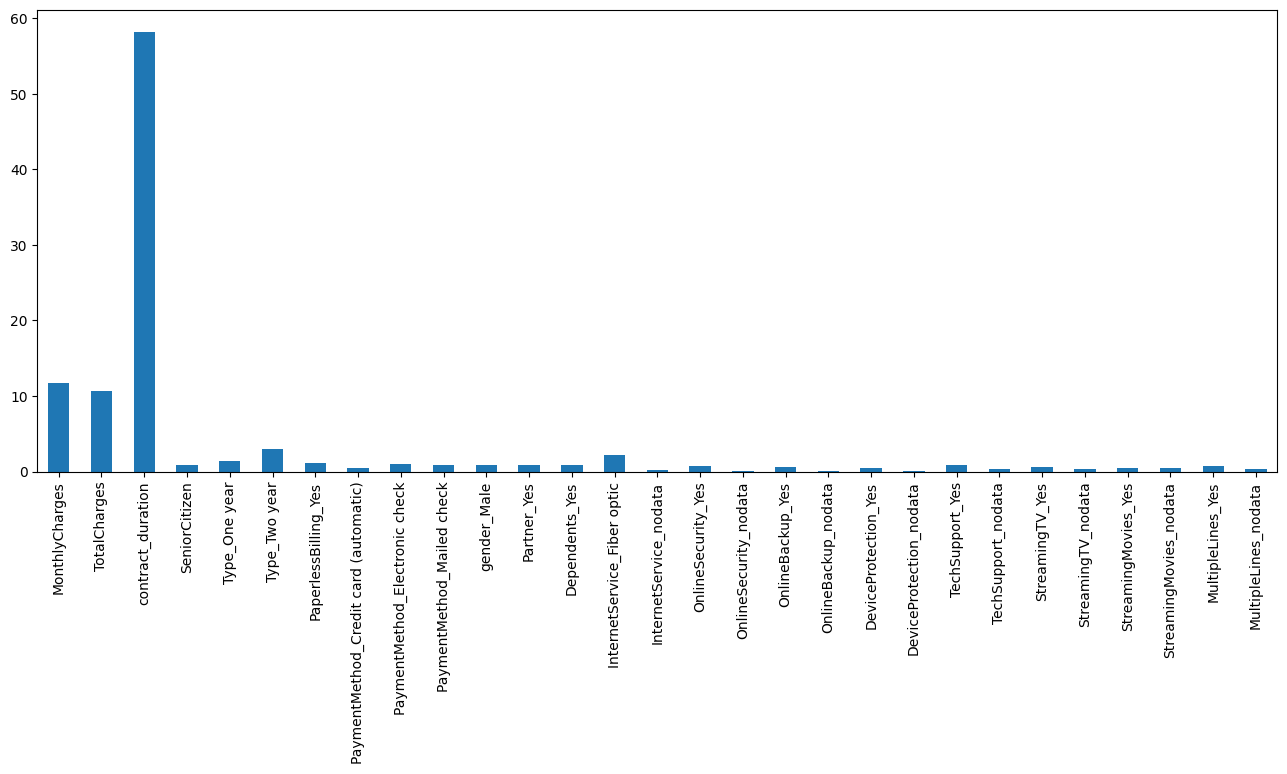

In [60]:
feature_results = pd.Series(importances, index=feature_list)
feature_results.plot(kind='bar', figsize = (16,6)) 
plt.show()

Вспомним предварительные выводы, и проверим, насколько они подтвердились:
- gender скорее всего можно отбросить без существенной потери качества модели
- признаки Device protection и OnlineBackup - претендуют на мультиколлнеарность, важен скорее всего только один.
- признаки OnlineSecurity и TechSupport - претендуют на мультиколлнеарность, важен скорее всего только один.
- StreamingTV и StreamingMovies претендуют на мультиколлнеарность, скорее всего отбросим, причем оба
- MultipleLines скорее всего можно отбросить без существенной потери качества модели
- Вероятно, признак TotalCharges не несет ценности для качества модели.
    
    
И отметим новые выводы и последующие шаги по "облегчению" модели:  
Что бросается в глаза, так это влияние признаков, которые мы выделили в отдельную категорию nodata, можно было смело добавлять в цже существующую категорию No и не плодить сущности, за исключением признакаа InternetService, где данное значение отделяет использование сервисом от не использования. Добавив признак "продолжительность контракта", мы получили 3 признака, по двум из которых можно достаточно точно определить третий, попробуем удалить TotalСharges, который имеет максимальную корреляцию с contract_duration. 
    
Пол клиента действительно не оказывает существенного влияния на работу модели, как и MultipleLines. Отбросим также и StreamingTV и StreamingMovies. Удалим OnlineSecurity но оставим TechSupport как более важный. OnlineBackup оставим, Device protection удалим как менее важный. Посмотрим, насколько "пострадает" качество модели в результате перечисленных изменений.
Для этого повторно проведем шаги по обучению модели:


In [61]:
data_light = data.copy()
data_light['OnlineBackup'] = data_light['OnlineBackup'].replace('nodata', 'No')
data_light['TechSupport'] = data_light['TechSupport'].replace('nodata', 'No')

data_light = data_light.drop(['TotalCharges', 'MultipleLines', 'gender', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'OnlineSecurity'], axis = 1)
display(data_light.head())


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,gone,contract_duration,SeniorCitizen,Partner,Dependents,InternetService,OnlineBackup,TechSupport
0,Month-to-month,Yes,Electronic check,29.85,0,31,0,Yes,No,DSL,Yes,No
1,One year,No,Mailed check,56.95,0,1036,0,No,No,DSL,No,No
2,Month-to-month,Yes,Mailed check,53.85,1,61,0,No,No,DSL,Yes,No
3,One year,No,Bank transfer (automatic),42.30,0,1371,0,No,No,DSL,No,Yes
4,Month-to-month,Yes,Electronic check,70.70,1,61,0,No,No,Fiber optic,No,No


In [62]:
data_light_ohe = pd.get_dummies(data_light, drop_first = True)


In [63]:
target = data_light_ohe['gone']
features = data_light_ohe.drop(['gone'], axis = 1)

#Подготовка обучающей и тестовой выборок:
features_train, features_second, target_train, target_second = train_test_split(features, target, test_size = 0.4, random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_second, target_second, test_size = 0.5, random_state = 12345)

#Проверка размерностей:
print(features_train.shape)
print(target_train.shape)

print(features_valid.shape)
print(target_valid.shape)

print(features_test.shape)
print(target_test.shape)

#Масшиабирование признаков:
scaler = StandardScaler()
scaler.fit(features[features.columns])

features_train[features.columns] = scaler.transform(features_train[features.columns])
features_valid[features.columns] = scaler.transform(features_valid[features.columns])
features_test[features.columns] = scaler.transform(features_test[features.columns])
display(features_train.head())

(4225, 15)
(4225,)
(1409, 15)
(1409,)
(1409, 15)
(1409,)


,MonthlyCharges,contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nodata,OnlineBackup_Yes,TechSupport_Yes
836,0.220630,1.206638,-0.439916,1.944582,-0.562975,-1.205113,1.904590,-0.711026,-0.544807,1.034530,1.529024,-0.885660,-0.525927,-0.725563,1.563872
1005,1.033249,0.840100,2.273159,1.944582,-0.562975,0.829798,1.904590,-0.711026,-0.544807,1.034530,-0.654012,1.129102,-0.525927,-0.725563,-0.639439
4220,-1.504315,0.923039,-0.439916,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,1.835513,1.034530,1.529024,-0.885660,1.901403,-0.725563,-0.639439
6543,-0.332748,1.206638,-0.439916,1.944582,-0.562975,-1.205113,1.904590,-0.711026,-0.544807,1.034530,1.529024,-0.885660,-0.525927,-0.725563,-0.639439
272,-1.328164,-1.278865,-0.439916,-0.514249,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807,-0.966622,-0.654012,-0.885660,-0.525927,-0.725563,-0.639439


In [64]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)
print()

(6427, 15)
(6427,)



In [65]:
%%time
best_model_cb = None
best_result = 0
best_depth = 0
best_lrate = 0

for depth in range(2, 7, 1):
    for lrate in [0.01, 0.05, 0.1]:
             
        model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = depth, iterations=500, learning_rate = lrate)
        model_cb.fit(features_upsampled, target_upsampled, verbose=100)
        cb_predictions = model_cb.predict(features_valid)
        cb_predictions_proba = model_cb.predict_proba(features_valid)[:,1]
        print('depth =', depth, 'learning rate =', lrate)
        print('Accuracy модели:',accuracy_score(target_valid, cb_predictions))
        print('ROC-AUC модели:',roc_auc_score(target_valid, cb_predictions_proba))
        print()        
        if roc_auc_score(target_valid, cb_predictions_proba) > best_result:
            best_result = roc_auc_score(target_valid, cb_predictions_proba)
            best_depth = depth
            best_lrate = lrate
            top_model_cb = model_cb
                
print('Наилучшие параметры модели: depth =', best_depth, 'learning rate =', best_lrate, '  ROC-AUC = ', best_result)

0:	total: 640us	remaining: 320ms
100:	total: 100ms	remaining: 395ms
200:	total: 196ms	remaining: 292ms
300:	total: 295ms	remaining: 195ms
400:	total: 394ms	remaining: 97.2ms
499:	total: 495ms	remaining: 0us
depth = 2 learning rate = 0.01
Accuracy модели: 0.7508871540099361
ROC-AUC модели: 0.8673282115856177

0:	total: 801us	remaining: 400ms
100:	total: 92.2ms	remaining: 364ms
200:	total: 197ms	remaining: 293ms
300:	total: 297ms	remaining: 197ms
400:	total: 410ms	remaining: 101ms
499:	total: 520ms	remaining: 0us
depth = 2 learning rate = 0.05
Accuracy модели: 0.7849538679914834
ROC-AUC модели: 0.881659843900549

0:	total: 649us	remaining: 324ms
100:	total: 105ms	remaining: 415ms
200:	total: 204ms	remaining: 304ms
300:	total: 313ms	remaining: 207ms
400:	total: 414ms	remaining: 102ms
499:	total: 515ms	remaining: 0us
depth = 2 learning rate = 0.1
Accuracy модели: 0.8105039034776437
ROC-AUC модели: 0.9028622480971874

0:	total: 972us	remaining: 485ms
100:	total: 118ms	remaining: 464ms
200:	

Подведем предварительные результаты:
- Признаков в 2 раза меньше
- обучение сушественно быстрее
- ROC AUC вместе с accuracy выросли..

In [66]:
%%time
best_model_cb = None
best_result = 0
best_depth = 0
best_lrate = 0

for lrate in np.arange(0.05, 0.202, 0.01):
             
    model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = 4, iterations=1000, learning_rate = lrate)
    model_cb.fit(features_upsampled, target_upsampled, verbose=200)
    cb_predictions = model_cb.predict(features_valid)
    cb_predictions_proba = model_cb.predict_proba(features_valid)[:,1]
    print('depth = 4, learning rate =', lrate)
    print('Accuracy модели:',accuracy_score(target_valid, cb_predictions))
    print('ROC-AUC модели:',roc_auc_score(target_valid, cb_predictions_proba))
    print()        
    if roc_auc_score(target_valid, cb_predictions_proba) > best_result:
        best_result = roc_auc_score(target_valid, cb_predictions_proba)
        best_depth = depth
        best_lrate = lrate
        top_model_cb = model_cb
                
print('Наилучшие параметры модели: learning rate =', best_lrate, '  ROC-AUC = ', best_result)

0:	total: 1.26ms	remaining: 1.26s
200:	total: 286ms	remaining: 1.14s
400:	total: 604ms	remaining: 903ms
600:	total: 927ms	remaining: 615ms
800:	total: 1.21s	remaining: 302ms
999:	total: 1.52s	remaining: 0us
depth = 4, learning rate = 0.05
Accuracy модели: 0.8459900638750887
ROC-AUC модели: 0.9216966511518834

0:	total: 1.12ms	remaining: 1.12s
200:	total: 294ms	remaining: 1.17s
400:	total: 602ms	remaining: 899ms
600:	total: 908ms	remaining: 603ms
800:	total: 1.2s	remaining: 299ms
999:	total: 1.5s	remaining: 0us
depth = 4, learning rate = 0.060000000000000005
Accuracy модели: 0.8552164655784245
ROC-AUC модели: 0.9251696345274449

0:	total: 1.74ms	remaining: 1.74s
200:	total: 278ms	remaining: 1.1s
400:	total: 599ms	remaining: 894ms
600:	total: 905ms	remaining: 601ms
800:	total: 1.22s	remaining: 303ms
999:	total: 1.52s	remaining: 0us
depth = 4, learning rate = 0.07
Accuracy модели: 0.8537970191625266
ROC-AUC модели: 0.9263600075449766

0:	total: 1.26ms	remaining: 1.26s
200:	total: 284ms	re

Оптимальные значения параметров неизменились. Теперь объединим train и valid и проведем повторное тестирование модели

In [67]:
target = data_light_ohe['gone']
features = data_light_ohe.drop(['gone'], axis = 1)

#Подготовка обучающей и тестовой выборок:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, random_state = 12345)

scaler = StandardScaler()
scaler.fit(features[features.columns])

features_train[features.columns] = scaler.transform(features_train[features.columns])
features_test[features.columns] = scaler.transform(features_test[features.columns])
display(features_train.head())



features_upsampled, target_upsampled = upsample(features_train, target_train, 3)

print(features_upsampled.shape)
print(target_upsampled.shape)
print()

,MonthlyCharges,contract_duration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,InternetService_nodata,OnlineBackup_Yes,TechSupport_Yes
1580,0.230601,-0.461512,2.273159,1.944582,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807,1.034530,-0.654012,-0.885660,-0.525927,1.378241,-0.639439
2902,0.310367,-1.072855,2.273159,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807,-0.966622,-0.654012,1.129102,-0.525927,-0.725563,-0.639439
410,0.551328,-1.195926,2.273159,-0.514249,-0.562975,0.829798,-0.525047,1.406418,-0.544807,-0.966622,-0.654012,1.129102,-0.525927,1.378241,-0.639439
6098,0.370192,-0.461512,-0.439916,1.944582,-0.562975,0.829798,-0.525047,-0.711026,-0.544807,1.034530,1.529024,-0.885660,-0.525927,-0.725563,-0.639439
2930,-1.296590,-0.054842,-0.439916,-0.514249,1.776278,-1.205113,-0.525047,-0.711026,1.835513,1.034530,1.529024,-0.885660,1.901403,-0.725563,-0.639439


(8614, 15)
(8614,)



In [68]:
%%time
model_cb = CatBoostClassifier(loss_function = 'Logloss', eval_metric = 'AUC', depth = 4, iterations=1000, learning_rate = 0.13)
model_cb.fit(features_upsampled, target_upsampled, verbose=200)

0:	total: 1.29ms	remaining: 1.29s
200:	total: 355ms	remaining: 1.41s
400:	total: 701ms	remaining: 1.05s
600:	total: 1.04s	remaining: 694ms
800:	total: 1.4s	remaining: 347ms
999:	total: 1.73s	remaining: 0us
CPU times: user 2.3 s, sys: 1.77 s, total: 4.07 s
Wall time: 1.79 s


In [69]:
cb_predictions = model_cb.predict(features_test)
cb_predictions_proba = model_cb.predict_proba(features_test)[:,1]

print('Accuracy модели:',accuracy_score(target_test, cb_predictions))
print('ROC-AUC модели:',roc_auc_score(target_test, cb_predictions_proba))

print('Полнота модели:',recall_score(target_test, cb_predictions))
print('Точность модели:', precision_score(target_test, cb_predictions))

Accuracy модели: 0.8644428672817601
ROC-AUC модели: 0.9312203806644977
Полнота модели: 0.8100263852242744
Точность модели: 0.7206572769953051


Подведем итоги, метрики Accuracy и ROC-AUC на облегченной выборке выросли примерно на 1-2%. Полнота увеличилась едва заметно, а вот точность прибавила 4%. Неплохой результат..

In [70]:
importances = model_cb.feature_importances_
feature_list = list(features_upsampled.columns)

feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

display(feature_results)

,feature,importance
0,contract_duration,69.663029
1,MonthlyCharges,15.215481
2,Type_Two year,2.772267
3,InternetService_Fiber optic,1.983450
4,Type_One year,1.270414
5,PaperlessBilling_Yes,1.164461
6,Dependents_Yes,1.117264
7,PaymentMethod_Electronic check,1.058043
8,TechSupport_Yes,1.057926
9,InternetService_nodata,0.995185


Вообще не влияющих признаков не осталось.. 

<a id="38"></a>
### Описание итоговых результатов и выводов

Проведя более полный исследовательский анализ данных и анализ влияния признаков на точность работы модели, мы избавились почти от половины признаков а также выявили не совсем удачные способы замены пропущенных значений, вот перечень изменений в исходной выборке, который был сделан для облегчения датасета:
- удален признак TotalCharges (мультиколлинеарность с продолжительностью договора)
- в столбцах OnlineBackup и TechSupport изменена категория 'nodata' на 'No', категорий осталось 2.
- удалены столбцы TotalCharges, MultipleLines, gender, DeviceProtection, StreamingTV, StreamingMovies, OnlineSecurity как практически не оказывающие влияния при построении модели
 
Повторный подбор параметров CatBoost привел нас к тем же оптимальным что и раньше. А вот метрики чувствительно подросли, да и скорость обучения заметно увеличилась:  метрики Accuracy и ROC-AUC на облегченной выборке выросли примерно на 1-2%.ROC-AUC достигла 0.93 Полнота увеличилась едва заметно, а вот точность прибавила 4%. 
    
Добавим, что по влиянию отток клиентов признаки можно разбить на следующие подгруппы:
- Наиболее ценные признаки: Продолжительность договора и ежемесячная стоимость услуги. Тут все ожидаемо, чем дольше времени с нами заключен договор, тем больше лояльность клиента. А переплачивать так уж точно никто не любит..
- Побочные признаки: Периодичность оплаты, тип подключения к сети интернет, способ оплаты, безналичный расчет, наличие иждивенцев. Может, какой-то из способов подключения действительно не так хорош, как у конкурентов?
- Практически не влияющие на отток: признаки, отражающие использование дополнительных услуг, пол, многоканальность звонков.
    
Среди мыслей, какие еще признаки могли бы помочь нам в улучшении прогнозирования оттока можно придумать следующие:
- периодичность обращений в службу поддержки
- количество и названия фирм-конкурентов, доступных по месту жительства клиента. Дополнительно может помочь понять, кому мы проигрываем..
- процет времени доступности услуг (или продолжительность аварий/ремонтов/...)
- объем предлагаемой скидки при прогнозе ухода, и ее влияние на изменение решения об уходе. Хотя это уже тянет на еще одну задачу моделирования, но также ценную.
